In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from category_encoders import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, RandomizedSearchCV, train_test_split

df = pd.read_csv('data.csv')

X = df.drop('overall_rating', axis=1)
y = df['overall_rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [2]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    return mse, mae, r2

def print_metrics(mse, mae, r2):
    print(f'MSE: {mse:.3f}')
    print(f'MAE: {mae:.3f}')
    print(f'R2: {r2:.3f}')

In [3]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold

def cv_evaluate(model, X, y):
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    scoring = {
        'r2': make_scorer(r2_score),
        'mae': make_scorer(mean_absolute_error),
        'mse': make_scorer(mean_squared_error)
    }
    cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring, return_train_score=False)

    for key in cv_results.keys():
        if key in ['fit_time', 'score_time']:
            continue
        print(f"{key}: {cv_results[key]}")
        print(f"{key} trung bình: {cv_results[key].mean():.3f} ± {cv_results[key].std():.3f}")
        print()

# Random Forest

## Default parameters

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from category_encoders import TargetEncoder

pipeline = Pipeline([
    ('encoder', TargetEncoder(cols=['nationality'])),
    ('model', RandomForestRegressor(random_state=42))
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('encoder', TargetEncoder(cols=['nationality'])),
                ('model', RandomForestRegressor(random_state=42))])

In [5]:
features_importance = pipeline.named_steps['model'].feature_importances_

feature_names = X_train.columns
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': features_importance
})
importance_df = importance_df.sort_values('importance', ascending=False)
importance_df = importance_df.reset_index(drop=True)
importance_df.T

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
feature,ball_control,age,standing_tackle,interceptions,nationality,positioning,marking,vision,heading_accuracy,finishing,...,positions_RM,positions_RB,positions_LB,positions_CB,positions_ST,positions_LW,positions_RW,positions_CF,positions_RWB,positions_LWB
importance,0.461899,0.151351,0.09568,0.04278,0.030755,0.028623,0.018104,0.017073,0.015745,0.010511,...,0.000105,0.000082,0.00008,0.000072,0.000062,0.000056,0.000053,0.000041,0.000034,0.00002


In [6]:
mse_train, mae_train, r2_train = evaluate_model(pipeline, X_train, y_train)
print('Training set:')
print_metrics(mse_train, mae_train, r2_train)

mse_test, mae_test, r2_test = evaluate_model(pipeline, X_test, y_test)
print('\nTest set:')
print_metrics(mse_test, mae_test, r2_test)

Training set:
MSE: 0.597
MAE: 0.502
R2: 0.988

Test set:
MSE: 4.095
MAE: 1.342
R2: 0.916


In [7]:
cv_evaluate(pipeline, X, y)

test_r2: [0.91654677 0.91153374 0.91359065 0.90470561 0.90656414]
test_r2 trung bình: 0.911 ± 0.004

test_mae: [1.34401114 1.33411978 1.34504876 1.38719142 1.38702981]
test_mae trung bình: 1.359 ± 0.023

test_mse: [4.05796635 4.25457078 4.1830988  4.50085575 4.58767576]
test_mse trung bình: 4.317 ± 0.198



## Bayesian optimization

In [12]:
import optuna

def objective(trial):

    rf = RandomForestRegressor(
        n_estimators=trial.suggest_int('n_estimators', 100, 500),
        max_depth=trial.suggest_int('max_depth', 5, 30),
        min_samples_split=trial.suggest_int('min_samples_split', 2, 30),
        min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 30),
        max_features=trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        random_state=42,
        n_jobs=-1
    )

    pipeline = Pipeline([
        ('encoder', TargetEncoder(cols=['nationality'])),
        ('model', rf)
    ])
    
    score = cross_val_score(pipeline, X_train, y_train, n_jobs=-1, cv=5, scoring='r2')
    
    return score.mean()


study = optuna.create_study(direction='maximize') 
study.optimize(objective, n_trials=100)  


print(f'Best parameters: {study.best_params}')

[I 2024-12-26 14:36:23,272] A new study created in memory with name: no-name-2d117b19-0806-419e-b42d-68525a4d46e2
[I 2024-12-26 14:36:26,298] Trial 0 finished with value: 0.8848821285984847 and parameters: {'n_estimators': 316, 'max_depth': 9, 'min_samples_split': 15, 'min_samples_leaf': 17, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.8848821285984847.
[I 2024-12-26 14:36:27,383] Trial 1 finished with value: 0.830643524087947 and parameters: {'n_estimators': 137, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 13, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.8848821285984847.
[I 2024-12-26 14:36:30,401] Trial 2 finished with value: 0.8733386031515415 and parameters: {'n_estimators': 366, 'max_depth': 8, 'min_samples_split': 28, 'min_samples_leaf': 20, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.8848821285984847.
[I 2024-12-26 14:36:31,425] Trial 3 finished with value: 0.8902827994397938 and parameters: {'n_estimators': 106, 'max_depth': 12, 

Best parameters: {'n_estimators': 483, 'max_depth': 20, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt'}


In [13]:
best_rf = RandomForestRegressor(
    n_estimators=study.best_params['n_estimators'],
    max_depth=study.best_params['max_depth'],
    min_samples_split=study.best_params['min_samples_split'],
    min_samples_leaf=study.best_params['min_samples_leaf'],
    max_features=study.best_params['max_features'],
    random_state=42,
    n_jobs=-1
)

best_pipeline = Pipeline([
    ('encoder', TargetEncoder(cols=['nationality'])),
    ('model', best_rf)
])
best_pipeline.fit(X_train, y_train)

Pipeline(steps=[('encoder', TargetEncoder(cols=['nationality'])),
                ('model',
                 RandomForestRegressor(max_depth=20, max_features='sqrt',
                                       min_samples_split=4, n_estimators=483,
                                       n_jobs=-1, random_state=42))])

In [14]:
print('Training set:')
print_metrics(*evaluate_model(pipeline, X_train, y_train))

print('\nTest set:')
print_metrics(*evaluate_model(pipeline, X_test, y_test))

Training set:
MSE: 0.597
MAE: 0.502
R2: 0.988

Test set:
MSE: 4.095
MAE: 1.342
R2: 0.916


In [15]:
cv_evaluate(best_pipeline, X, y)

test_r2: [0.92476342 0.91918745 0.92333548 0.91386893 0.91562794]
test_r2 trung bình: 0.919 ± 0.004

test_mae: [1.24304263 1.2200778  1.21090671 1.26828551 1.27870653]
test_mae trung bình: 1.244 ± 0.026

test_mse: [3.65842645 3.88648434 3.71134891 4.06806218 4.14264567]
test_mse trung bình: 3.893 ± 0.190



In [39]:
bayes_rf = best_pipeline.named_steps['model']

In [65]:
import joblib

joblib.dump(bayes_rf, 'bayes_rf.pkl')
print("Mô hình RF tối ưu bằng Bayesian đã được lưu thành công dưới tên 'bayes_rf.pkl'")

Mô hình RF tối ưu bằng Bayesian đã được lưu thành công dưới tên 'bayes_rf.pkl'


## Grid Seach

In [34]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'rf__n_estimators': [150, 200, 250],
    'rf__max_depth': [10, 15, 20],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__max_features': ['log2', 'sqrt', None]
}
model = Pipeline([
    ('encoder', TargetEncoder(cols=['nationality'])),
    ('rf', RandomForestRegressor(
        random_state=42,
        n_jobs=-1
    ))
])
cv = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(model, param_grid, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('encoder',
                                        TargetEncoder(cols=['nationality'])),
                                       ('rf',
                                        RandomForestRegressor(n_jobs=-1,
                                                              random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [10, 15, 20],
                         'rf__max_features': ['log2', 'sqrt', None],
                         'rf__min_samples_leaf': [1, 2, 4],
                         'rf__min_samples_split': [2, 5, 10],
                         'rf__n_estimators': [150, 200, 250]},
             scoring='neg_mean_squared_error')

In [35]:
model = grid_search.best_estimator_
print('Best params:', grid_search.best_params_)

Best params: {'rf__max_depth': 20, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}


In [38]:
model.fit(X_train, y_train)
print('Training set:')
print_metrics(*evaluate_model(model, X_train, y_train))

print('\nTest set:')
print_metrics(*evaluate_model(model, X_test, y_test))

Training set:
MSE: 0.588
MAE: 0.485
R2: 0.988

Test set:
MSE: 3.793
MAE: 1.266
R2: 0.923


In [37]:
cv_evaluate(model, X, y)

test_r2: [0.92393606 0.91836667 0.92327694 0.91308862 0.9149971 ]
test_r2 trung bình: 0.919 ± 0.004

test_mae: [1.25638319 1.23444954 1.21795267 1.27881687 1.28691916]
test_mae trung bình: 1.255 ± 0.026

test_mse: [3.69865724 3.92595785 3.714183   4.10491738 4.17361983]
test_mse trung bình: 3.923 ± 0.195



In [41]:
grid_rf = model.named_steps['rf']

In [57]:
import joblib

joblib.dump(grid_rf, 'grid_rf.pkl')
print("Mô hình RF tối ưu bằng Grid Search đã được lưu thành công dưới tên 'grid_rf.pkl'")

Mô hình RF tối ưu bằng Grid Search đã được lưu thành công dưới tên 'grid_rf.pkl'


## GA to find optimal parameters

In [49]:
def create_individual():
    n_estimators = np.random.randint(100, 300)
    max_depth = np.random.randint(5, 25)
    min_samples_split = np.random.randint(2, 50)
    max_features = np.random.choice(['sqrt', 'log2', None])
    return [n_estimators, max_depth, min_samples_split, max_features]

def fitness(individual):
    n_estimators, max_depth, min_samples_split, max_features = individual
    model = Pipeline([
        ('te', TargetEncoder(cols=['nationality'])),
        ('rf', RandomForestRegressor(
            n_estimators=n_estimators, 
            max_depth=max_depth, 
            min_samples_split=min_samples_split, 
            max_features=max_features, 
            random_state=42
        ))
    ])

    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
    return -scores.mean(),

def create_population(pop_size):
    return [create_individual() for _ in range(pop_size)]

def crossover(ind1, ind2, crossover_rate=0.9):
    child1, child2 = ind1[:], ind2[:]
    if np.random.rand() < crossover_rate:
        crossover_point = np.random.randint(1, len(ind1))
        child1 = ind1[:crossover_point] + ind2[crossover_point:]
        child2 = ind2[:crossover_point] + ind1[crossover_point:]
    return child1, child2

def mutate(individual, mutate_rate=0.05):
    mutated = individual[:]
    for i in range(len(mutated)):
        if np.random.rand() < mutate_rate:
            mutated[i] = create_individual()[i]
    return mutated

In [50]:
def GA(pop_size, generations, generations_values, fitness_values):
    population = create_population(pop_size)

    for generation in range(generations):
        scores = [fitness(ind) for ind in population]
        sorted_scores = sorted(scores, key=lambda x: x[0])
        sorted_population = [ind for ind, score in sorted(zip(population, scores), key=lambda x: x[1])]

        print(f'\nGeneration {generation + 1}: Best MSE: {sorted_scores[0][0]:.3f}')
        print(f'Solution: {sorted_population[0]}')
        
        generations_values.append(generation + 1)
        fitness_values.append(sorted_scores[0][0])

        # Elitism
        parents = sorted_population[:5]
        next_generation = parents[:]

        while len(next_generation) < pop_size:
            # Selection
            idx1 = np.random.randint(0, len(parents))
            while True:
                idx2 = np.random.randint(0, len(parents))
                if idx2 != idx1:
                    break
            parent1, parent2 = parents[idx1], parents[idx2]

            # Crossover
            child1, child2 = crossover(parent1, parent2)

            # Mutation
            child1 = mutate(child1)
            child2 = mutate(child2)

            next_generation.extend([child1, child2])

        population = next_generation
    
    scores = [fitness(ind) for ind in population]
    sorted_scores = sorted(scores, key=lambda x: x[0])
    sorted_population = [ind for ind, score in sorted(zip(population, scores), key=lambda x: x[1])]
    return sorted_population[0]

In [51]:
pop_size = 50
generations = 30

generation_values = []
fitness_values = []

best_individual = GA(pop_size, generations, generation_values, fitness_values)
best_individual


Generation 1: Best MSE: 4.020
Solution: [193, 23, 6, 'sqrt']

Generation 2: Best MSE: 4.010
Solution: [253, 19, 3, 'sqrt']

Generation 3: Best MSE: 4.000
Solution: [287, 19, 3, 'sqrt']

Generation 4: Best MSE: 4.000
Solution: [287, 19, 3, 'sqrt']

Generation 5: Best MSE: 4.000
Solution: [287, 19, 3, 'sqrt']

Generation 6: Best MSE: 4.000
Solution: [287, 19, 3, 'sqrt']

Generation 7: Best MSE: 4.000
Solution: [287, 19, 3, 'sqrt']

Generation 8: Best MSE: 4.000
Solution: [287, 19, 3, 'sqrt']

Generation 9: Best MSE: 3.999
Solution: [287, 24, 3, 'sqrt']

Generation 10: Best MSE: 3.999
Solution: [287, 24, 3, 'sqrt']

Generation 11: Best MSE: 3.999
Solution: [287, 24, 3, 'sqrt']

Generation 12: Best MSE: 3.999
Solution: [287, 24, 3, 'sqrt']

Generation 13: Best MSE: 3.999
Solution: [287, 24, 3, 'sqrt']

Generation 14: Best MSE: 3.999
Solution: [287, 24, 3, 'sqrt']

Generation 15: Best MSE: 3.999
Solution: [287, 24, 3, 'sqrt']

Generation 16: Best MSE: 3.999
Solution: [287, 24, 3, 'sqrt']



[293, 24, 2, 'sqrt']

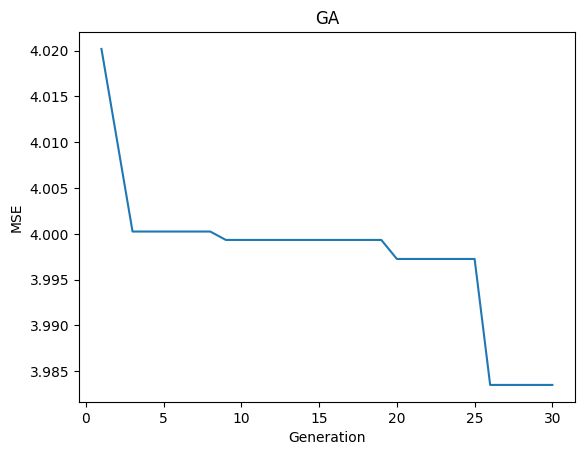

In [52]:
import matplotlib.pyplot as plt

plt.plot(generation_values, fitness_values)
plt.xlabel('Generation')
plt.ylabel('MSE')
plt.title('GA')
plt.show()

In [53]:
best_individual

[293, 24, 2, 'sqrt']

In [54]:
ga_model = Pipeline([
    ('te', TargetEncoder(cols=['nationality'])),
    ('rf', RandomForestRegressor(
        n_estimators=best_individual[0], 
        max_depth=best_individual[1], 
        min_samples_split=best_individual[2], 
        max_features=best_individual[3], 
        random_state=42
    ))
])
ga_model.fit(X_train, y_train)

Pipeline(steps=[('te', TargetEncoder(cols=['nationality'])),
                ('rf',
                 RandomForestRegressor(max_depth=24, max_features='sqrt',
                                       n_estimators=293, random_state=42))])

In [58]:
print('Training set:')
print_metrics(*evaluate_model(ga_model, X_train, y_train))

print('\nTest set:')
print_metrics(*evaluate_model(ga_model, X_test, y_test))

Training set:
MSE: 0.538
MAE: 0.462
R2: 0.989

Test set:
MSE: 3.805
MAE: 1.269
R2: 0.922


In [59]:
cv_evaluate(ga_model, X, y)

test_r2: [0.92394309 0.91960746 0.92389828 0.91374745 0.91499323]
test_r2 trung bình: 0.919 ± 0.004

test_mae: [1.25475436 1.22261882 1.214569   1.27038247 1.28587328]
test_mae trung bình: 1.250 ± 0.027

test_mse: [3.69831557 3.86628461 3.68410344 4.07379991 4.17380995]
test_mse trung bình: 3.899 ± 0.197



In [55]:
features_importance = ga_model.named_steps['rf'].feature_importances_

feature_names = X_train.columns
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': features_importance
})
importance_df = importance_df.sort_values('importance', ascending=False)
importance_df = importance_df.reset_index(drop=True)
importance_df.T

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
feature,ball_control,age,short_passing,dribbling,standing_tackle,interceptions,positioning,vision,marking,sliding_tackle,...,positions_CAM,positions_RM,positions_LB,positions_RB,positions_LM,positions_RW,positions_LW,positions_CF,positions_RWB,positions_LWB
importance,0.117165,0.0755,0.069174,0.058637,0.056215,0.055282,0.052036,0.046335,0.04351,0.037052,...,0.000237,0.000232,0.000224,0.000221,0.000214,0.000113,0.000109,0.000068,0.000058,0.000053


In [56]:
ga_rf = ga_model.named_steps['rf']

import joblib

joblib.dump(ga_rf, 'ga_rf.pkl')
print("Mô hình RF tối ưu bằng GA đã được lưu thành công dưới tên 'ga_rf.pkl'")

Mô hình RF tối ưu bằng GA đã được lưu thành công dưới tên 'ga_rf.pkl'


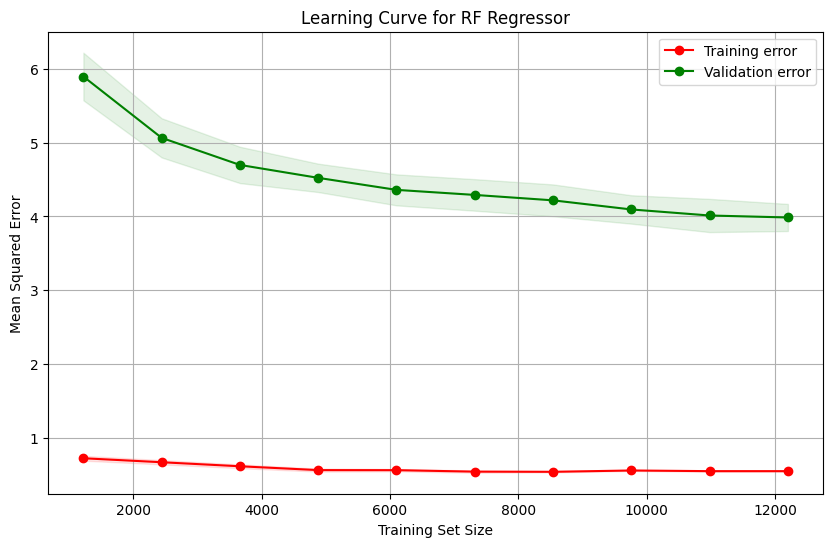

In [60]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    ga_model,
    X_train,
    y_train,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.title("Learning Curve for RF Regressor")
plt.xlabel("Training Set Size")
plt.ylabel("Mean Squared Error")

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training error")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Validation error")

plt.legend(loc="best")
plt.grid()
plt.show()

# XGBoost

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
# X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [5]:
from xgboost import XGBRegressor

pipeline = Pipeline([
    ('encoder', TargetEncoder(cols=['nationality'])),
    ('model', XGBRegressor(random_state=42))
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('encoder', TargetEncoder(cols=['nationality'])),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [6]:
print('Training set:')
print_metrics(*evaluate_model(pipeline, X_train, y_train))

print('\nTest set:')
print_metrics(*evaluate_model(pipeline, X_test, y_test))

Training set:
MSE: 0.700
MAE: 0.625
R2: 0.985

Test set:
MSE: 3.796
MAE: 1.235
R2: 0.922


In [7]:
cv_evaluate(pipeline, X, y)

test_r2: [0.92197579 0.91287965 0.91783595 0.91151559 0.91513622]
test_r2 trung bình: 0.916 ± 0.004

test_mae: [1.24667401 1.26177407 1.25224155 1.27784943 1.27810129]
test_mae trung bình: 1.263 ± 0.013

test_mse: [3.79397667 4.1898423  3.97758366 4.1792129  4.16678714]
test_mse trung bình: 4.061 ± 0.155



## Grid Search

In [ ]:
param_grid = {
    'xgb__n_estimators': [100, 200, 300],
    'xgb__max_depth': [3, 5, 7, 9],
    'xgb__learning_rate': [0.05, 0.1, 0.3],
    'xgb__subsample': [0.5, 0.8, 1],
    'xgb__colsample_bytree': [0.5, 0.8, 1],
    'xgb__gamma': [0, 0.1, 0.2]
}

In [8]:
xgb = XGBRegressor(
    max_depth=5, 
    n_estimators=1000, 
    learning_rate=0.05, 
    subsample=0.8,
    colsample_bytree=0.8, 
    reg_alpha=1, reg_lambda=1, gamma=5, 
    random_state=42, 
    n_jobs=-1
)
pipeline = Pipeline([
    ('encoder', TargetEncoder(cols=['nationality'])),
    ('xgb', xgb)
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('encoder', TargetEncoder(cols=['nationality'])),
                ('xgb',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=0.8, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=5, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=5, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=1000, n_jobs=-1,
                              num_parallel_tree=None, random_state=42, ...))])

In [9]:
print('Training set:')
print_metrics(*evaluate_model(pipeline, X_train, y_train))

print('\nTest set:')
print_metrics(*evaluate_model(pipeline, X_test, y_test))

Training set:
MSE: 0.901
MAE: 0.700
R2: 0.981

Test set:
MSE: 3.224
MAE: 1.126
R2: 0.934


In [10]:
cv_evaluate(pipeline, X, y)

test_r2: [0.93420011 0.92824382 0.93094236 0.92382753 0.928397  ]
test_r2 trung bình: 0.929 ± 0.003

test_mae: [1.11140967 1.11901977 1.11128243 1.14532412 1.13553598]
test_mae trung bình: 1.125 ± 0.014

test_mse: [3.1995607  3.4509414  3.34309855 3.59770601 3.51568889]
test_mse trung bình: 3.421 ± 0.139



## Bayes optimization

In [19]:
import optuna

def objective(trial):
    
    xgb = XGBRegressor(
        n_estimators=trial.suggest_int('n_estimators', 100, 300),
        max_depth=trial.suggest_int('max_depth', 5, 25),
        learning_rate=trial.suggest_loguniform('learning_rate', 0.001, 0.5),
        subsample=trial.suggest_uniform('subsample', 0.5, 1),
        colsample_bytree=trial.suggest_uniform('colsample_bytree', 0.5, 1),
        gamma=trial.suggest_loguniform('gamma', 0.001, 1),
        random_state=42,
        n_jobs=-1
    )

    pipeline = Pipeline([
        ('encoder', TargetEncoder(cols=['nationality'])),
        ('model', xgb)
    ])

    score = cross_val_score(pipeline, X_train, y_train, n_jobs=-1, cv=5, scoring='r2')

    return score.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print(f'Best parameters: {study.best_params}')

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-12-26 11:20:43,967] A new study created in memory with name: no-name-68910972-fa51-4504-8463-3e2e7ea37419
C:\Users\Admin\AppData\Local\Temp\ipykernel_20724\3250995161.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 0.001, 0.5),
C:\Users\Admin\AppData\Local\Temp\ipykernel_20724\3250995161.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample

Best parameters: {'n_estimators': 193, 'max_depth': 8, 'learning_rate': 0.07432060766334897, 'subsample': 0.766858138504603, 'colsample_bytree': 0.5009243448601723, 'gamma': 0.006086613916385964}


In [20]:
best_xgb = XGBRegressor(
    n_estimators=study.best_params['n_estimators'],
    max_depth=study.best_params['max_depth'],
    learning_rate=study.best_params['learning_rate'],
    subsample=study.best_params['subsample'],
    colsample_bytree=study.best_params['colsample_bytree'],
    gamma=study.best_params['gamma'],
    random_state=42,
    n_jobs=-1
)

best_pipeline = Pipeline([
    ('encoder', TargetEncoder(cols=['nationality'])),
    ('model', best_xgb)
])
best_pipeline.fit(X_train, y_train)

Pipeline(steps=[('encoder', TargetEncoder(cols=['nationality'])),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=0.5009243448601723, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=0.006086613916385964,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.07432060766334897, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=8, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=193, n_jobs=-1,
                              num_parallel_tree=None, random_state=42, ...))])

In [12]:
print('Training set:')
print_metrics(*evaluate_model(best_pipeline, X_train, y_train))

print('\nTest set:')
print_metrics(*evaluate_model(best_pipeline, X_test, y_test))

Training set:
MSE: 0.405
MAE: 0.473
R2: 0.992

Test set:
MSE: 3.129
MAE: 1.087
R2: 0.936


In [13]:
cv_evaluate(best_pipeline, X, y)

test_r2: [0.93741846 0.92969227 0.9327938  0.92520493 0.92913997]
test_r2 trung bình: 0.931 ± 0.004

test_mae: [1.09002979 1.08787357 1.08555973 1.12103057 1.11125329]
test_mae trung bình: 1.099 ± 0.014

test_mse: [3.04306795 3.3812799  3.25346843 3.53265188 3.47920692]
test_mse trung bình: 3.338 ± 0.175

